# Final Project Group 3

In [1]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(patchwork)
library(dplyr)
library(leaps)
library(car)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode




## (1) Introduction
>Start with relevant background information on the topic to prepare those unfamiliar for the rest of your proposal.

>Formulate one or two questions for investigation and detail the dataset that will be utilized to address these questions.

> Additionally, align your question/objectives with the existing literature. To contextualize your study, include a minimum of two scientific publications (these should be listed in the References section).

Tipping is a social norm in North America and many research looked into factors affecting tipping behavior. Lynn and McCall (2000) investigated how service quality ratings affect tipping amount, as expected, they found positive correlation. However, this is not the whole picture, Lynn pointed out there are other factors such as costomer mood, also contributing to changes in tipping amount. Data from the US(Peck and Deehan, 2024) shows tips make up on average, 22.6% of a restaurant workers' income. Thus it is important to try to analyze and understand what affect tipping behavior so workers could make changes and potentially earn more.

We are given dataset `tips.csv` from https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset, and the variables are:

1. `total_bill`:Total bill amount in dollars.         _numerical_
2. `tip`: Tip amount in dollars.                      _numerical_
4. `sex`:Gender of the costomer paying.               _Male or Female, binary_
5. `smoker`: Whether the costomer paying is a smoker. _Yes or no, binary_
6. `day`: Day of the week of the transaction.         _Thur/Fri/Sat/Sun, categorical_
7. `time`:Time of day of transaction.                 _Lunch/Dinner, binary_
8. `size`:Size of the dining party.                   _numerical_

### Research Question:

Which factors from total bill amount, sex, smoker or not, day, time and party size determine tip percentage? (Feel free to adjust the wording if needed)

## (2) Methods and Results
In this section, you will include:

> a) “Exploratory Data Analysis (EDA)”

> Demonstrate that the dataset can be read into R.
Clean and wrangle your data into a tidy format.
Plot the relevant raw data, tailoring your plot to address your question.
Make sure to explore the association of the explanatory variables with the response.
Any summary tables that are relevant to your analysis.
Be sure not to print output that takes up a lot of screen space.
Your EDA must be comprehensive with high quality plots.



### a) EDA

In [2]:
# Main developer: Dominique
# Contributer: Tara (created git link)
url <- "https://raw.githubusercontent.com/tarauboviccc/stat301_project/main/tips.csv" 
dt_tip <- read.csv(url) 
tip<-dt_tip|>mutate(size=factor(size),
                    sex=as.factor(sex),
                    smoker=as.factor(smoker),
                    day=as.factor(day),
                    time=as.factor(time),
          tip_pct=tip/total_bill)
tip|>count(size)
tip|>count(day)

size,n
<fct>,<int>
1,4
2,156
3,38
4,37
5,5
6,4


day,n
<fct>,<int>
Fri,19
Sat,87
Sun,76
Thur,62


* As number of observations from party size of more than two people are limited, we could combine `size` into two levels: 2- or 2+.
* Friday and Thursday has smaller number of observations compared to the weekends, we could combine `day` into two levels: weekdays(wkyd) or weekends(wknd).

In [3]:
#Main Contributer: Dominique
tip <- tip %>%
    mutate(
        size = fct_collapse(size, '2-'=c('1','2'),'2+' = c('3','4','5','6')),
        day=fct_collapse(day,'wkyd'=c('Fri','Thur'),'wknd'=c('Sat','Sun')))

tip %>% count(size,sort = TRUE)
tip %>% count(day,sort = TRUE)


size,n
<fct>,<int>
2-,160
2+,84


day,n
<fct>,<int>
wknd,163
wkyd,81


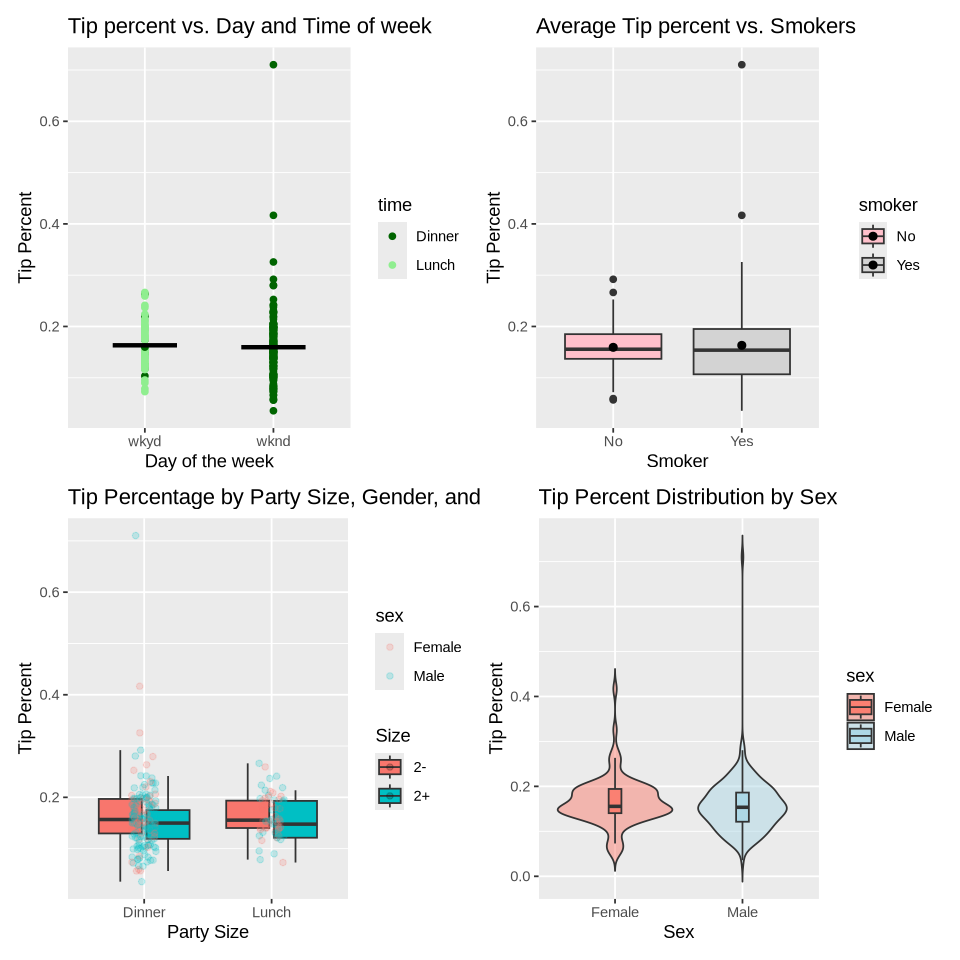

In [4]:
#Main Developer: Dominique, Lexi
options(repr.plot.width = 8, repr.plot.height = 8)

tip_explore_plot <- 
    tip |>
    ggplot(aes(x = day, y = tip_pct, color = time))+
    geom_point()+
    stat_summary(fun = mean, geom = "crossbar", width = 0.5, color = "black")+
    scale_color_manual(values = c("Lunch" = "lightgreen", "Dinner" = "darkgreen")) +
    labs(title="Tip percent vs. Day and Time of week",
         x="Day of the week",
         y="Tip Percent")

tip_box_plot <- tip |>
  ggplot(aes(x = smoker, y = tip_pct, fill = smoker)) +
  geom_boxplot() +
  stat_summary(fun = mean, geom = "point", shape = 20, size = 3, color = "black") +
  scale_fill_manual(values = c("Yes" = "lightgray", "No" = "pink")) +
  labs(title = "Average Tip percent vs. Smokers",
       x = "Smoker",
       y = "Tip Percent")

# size_bar_plot<-tip %>%
#   ggplot(aes(x = size, y = tip_pct)) +
#   geom_bar(stat = "summary", fun = "mean", fill = "lightblue",width=0.5) +
#   labs(title = "Average Tip Percentage by Group Size",
#        x = "Group Size",
#        y = "Average Tip Percentage") 

tips_vis <- tip %>%
    ggplot(aes(x = time, y = tip_pct,fill=size)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(aes(color = sex), width = 0.1, alpha = 0.2) +
    labs(
        title = "Tip Percentage by Party Size, Gender, and Time of Day",
        x = "Party Size",
        y = "Tip Percent",
        fill = "Size"
    ) 

gender_violin_plot <- tip |>
  ggplot(aes(x = sex, y = tip_pct, fill = sex)) +
  geom_violin(trim = FALSE, alpha = 0.5) +
  geom_boxplot(width = 0.1, outlier.shape = NA) +
  scale_fill_manual(values = c("Female" = "salmon", "Male" = "lightblue"))+
  labs(title = "Tip Percent Distribution by Sex",
       x = "Sex",
       y = "Tip Percent")
       

combined_plot <-  (tip_explore_plot + tip_box_plot) / (tips_vis+gender_violin_plot)
combined_plot

From the plots we learned:
1. More transactions happen on weekend dinner hours.
2. Tipping percentage does not differ a lot between smoker and non-smokers
3. Group size smaller and equal to 2 tip more percentage than groups greater than 2.
4. Females and males tip similar percentage on average, with males showing more outliers.

> b) “Methods: Plan”

> Describe in written English the methods you used to perform your analysis from beginning to end, and narrate the code that does the analysis.
>If included, describe the “Feature Selection” process and how and why you choose the covariates of your final model.
>Make sure to interpret/explain the results you obtain. It’s not enough to just say, “I fitted a linear model with these covariates, and my R-square is 0.87”.
>If inference is the aim of your project, a detailed interpretation of your fitted model is required, as well as a discussion of relevant quantities (e.g., are the coefficients significant? How does the model fit the data)?
A careful model assessment must be conducted.

### b) Methods: Plan

* We first split the data into selection(30%) and training(70%), and use the training data to do feature selection.

In [5]:
# Split the data into training data and selection set data on a 70-30% basis
#Main developer: Lexi
#Contributer: Dominique

set.seed(123)
training_tips <- 
    tip %>%
    slice_sample(prop = 0.7, replace = FALSE)
selection_tips <- 
    tip %>%
    anti_join(training_tips, by = names(tip))
#Remove total_bill and tip as they are components of tip_pct
training_tips <- training_tips |> 
    select(-total_bill, -tip)
selection_tips <- selection_tips |> 
    select(-total_bill, -tip)

head(training_tips,2)
nrow(training_tips)
head(selection_tips,2)
nrow(selection_tips)

,sex,smoker,day,time,size,tip_pct
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,Female,No,wknd,Dinner,2-,0.1949216
2,Male,Yes,wknd,Dinner,2+,0.1282437


[1] 170

,sex,smoker,day,time,size,tip_pct
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,Male,No,wknd,Dinner,2+,0.1605416
2,Male,No,wknd,Dinner,2+,0.1665873


[1] 74

### Feature Selection

* We decide to use Forward Selection with all the variables, and observe the change in $R^2$ to decide which ones to keep.

In [6]:
#Main developer: Dominique
#Contributer:Lexi, Tara
tip_forward_sel <- leaps::regsubsets(
  x=tip_pct~., 
  nvmax=7,
  data=selection_tips,
  method="forward",
)
tip_forward_sel_summary<- summary(tip_forward_sel)
tip_forward_sel_summary

Subset selection object
Call: regsubsets.formula(x = tip_pct ~ ., nvmax = 7, data = selection_tips, 
    method = "forward", )
5 Variables  (and intercept)
          Forced in Forced out
sexMale       FALSE      FALSE
smokerYes     FALSE      FALSE
daywknd       FALSE      FALSE
timeLunch     FALSE      FALSE
size2+        FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: forward
         sexMale smokerYes daywknd timeLunch size2+
1  ( 1 ) "*"     " "       " "     " "       " "   
2  ( 1 ) "*"     " "       "*"     " "       " "   
3  ( 1 ) "*"     " "       "*"     "*"       " "   
4  ( 1 ) "*"     " "       "*"     "*"       "*"   
5  ( 1 ) "*"     "*"       "*"     "*"       "*"   

In [7]:
#Check for adjr2 to select variables
#Main Developer: Dominique
#Contributer: Lexi
tip_forward_summary_df <- 
    tibble(
        n_input_variables = 1:5,
        ADJ.R2 = tip_forward_sel_summary$adjr2
    )
tip_forward_summary_df

n_input_variables,ADJ.R2
<int>,<dbl>
1,0.0145797576
2,0.0259868105
3,0.0138271329
4,-0.0003045863
5,-0.0149637754


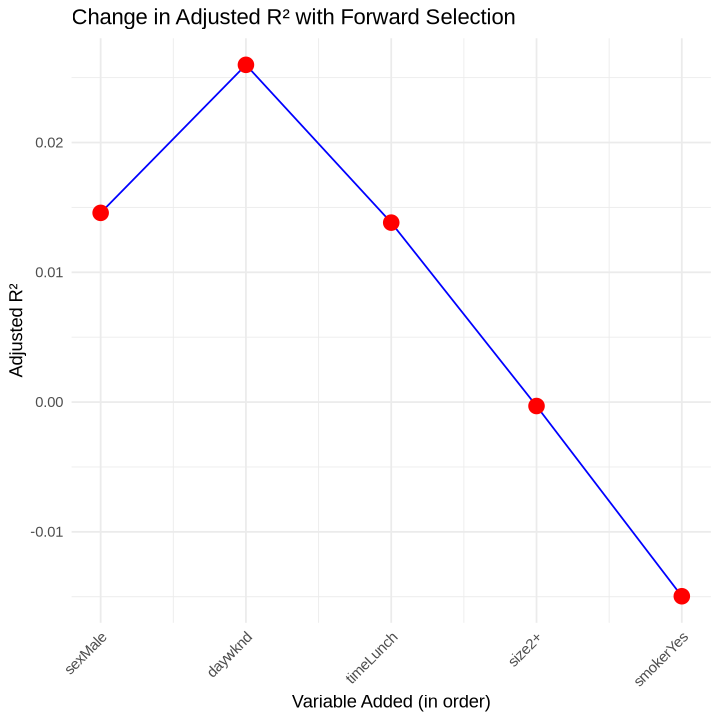

In [8]:
#Main Developer:Dominique
#Contributer:Tara, Lexi
options(repr.plot.width = 6, repr.plot.height = 6)
variable_names <- c("sexMale", "daywknd","timeLunch",'size2+',"smokerYes")
ggplot(tip_forward_summary_df, aes(x = n_input_variables, y = ADJ.R2)) +
  geom_line(group = 1, color = "blue") +
  geom_point(color = "red", size = 4) +
  scale_x_continuous(
    breaks = tip_forward_summary_df$n_input_variables, 
    labels = variable_names                           
  ) +
  labs(
    x = "Variable Added (in order)",
    y = "Adjusted R²",
    title = "Change in Adjusted R² with Forward Selection"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## (3) Discussion
> In this section, you’ll interpret the results you obtained in the previous section with respect to the main question/goal of your project.

> Summarize what you found and the implications/impact of your findings.
If relevant, discuss whether your results were what you expected to find.
Discuss how your model could be improved;
Discuss future questions/research this study could lead to.

## (4) References
> At least two citations of literature relevant to the project. The citation format is your choice – just be consistent. Make sure to cite the source of your data as well.
*I'm using MLA -Dominique

Lynn, M., & McCall, M. (2000). Gratitude and gratuity: A meta-analysis of research on the service–tipping relationship. The Journal of Socio-Economics, 29(2), 203–214. https://doi.org/10.1016/S1053-5357(00)00062-7

Peck, E., & Deehan, M. (2024, November 18). Tips make up large share of Mass. Restaurant Workers’ pay - axios Boston. AXIOS Boston. https://www.axios.com/local/boston/2024/11/18/tips-restaurant-workers-pay-massachusetts 